In [15]:
import loss_landscapes
from loss_landscapes import random_plane, metrics, ModelWrapper
import torch
from torch.nn import functional as F

experiment_id = "189454739472380536"
run_id = "48ebf24973744164844891aa7584ff54"
trained_model = torch.load(f"mlruns/{experiment_id}/{run_id}/artifacts/best_model/data/model.pth", weights_only=False)

In [28]:
import abc
import numpy as np

class Metric(abc.ABC):
    """ A quantity that can be computed given a model or an agent. """

    def __init__(self):
        super().__init__()

    @abc.abstractmethod
    def __call__(self, model_wrapper: ModelWrapper):
        pass


class Loss(Metric):
    """ Computes a specified loss function over specified input-output pairs. """
    def __init__(self, loss_fn, inputs, labels):
        super().__init__()
        self.loss_fn = loss_fn
        self.inputs = inputs
        self.labels = labels
        
    def __call__(self, model_wrapper: ModelWrapper) -> float:
        return float(self.loss_fn(model_wrapper.forward(self.inputs), self.labels))

In [23]:
from dataset import MnistDataset
from torch.utils.data import DataLoader
eval_dataset = MnistDataset(
    num_instances= 32,
    num_samples_per_class = 5,
    digit_arr = list(range(0,10)),
    ucc_start= 1,
    ucc_end= 4,
    mode= "test",
    length= 10000
)
eval_dataloader = DataLoader(eval_dataset, 32)
tensors = []
labels = []
for batch_samples, batch_labels in eval_dataloader:
    with torch.no_grad():
        feature_distributions = trained_model.extract_features(batch_samples.to(torch.device("mps")))
        for feature in feature_distributions.detach().cpu():
            tensors.append(feature)
        for l in batch_labels:  
            labels.append(l)



x_train shape: torch.Size([50000, 1, 28, 28])
50000 train samples
10000 val samples
tensor(0.3105)
tensor(0.1325)
10000 test samples


In [27]:
inputs = torch.stack(tensors, dim=0)
labels = torch.stack(labels)

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [30]:
trained_model = trained_model.to("cpu")
drn_model = trained_model.ucc_classifier

In [31]:
metrics = Loss(F.cross_entropy, inputs, labels)
random_landscape = random_plane(drn_model, metrics)

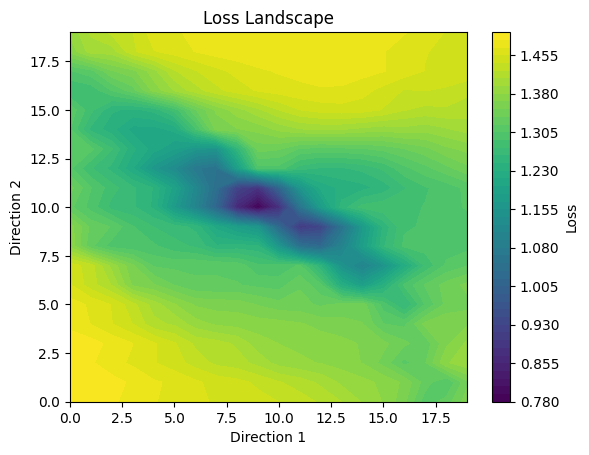

In [38]:
import matplotlib.pyplot as plt

plt.contourf(random_landscape, levels=50, cmap='viridis')
plt.colorbar(label='Loss')
plt.title("Loss Landscape")
plt.xlabel("Direction 1")
plt.ylabel("Direction 2")
plt.show()


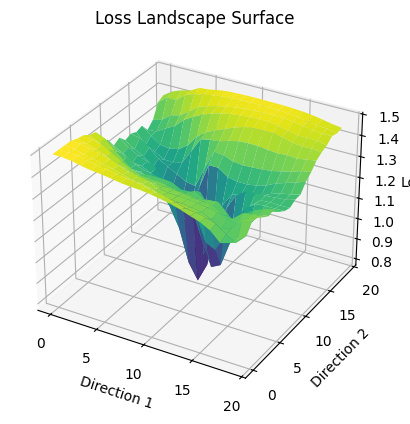

In [41]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

X, Y = np.meshgrid(range(20), range(20))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, random_landscape, cmap='viridis')
ax.set_xlabel('Direction 1')
ax.set_ylabel('Direction 2')
ax.set_zlabel('Loss')
plt.title("Loss Landscape Surface")
plt.show()


In [1]:
from model import UCCDRNModel
from hydra import initialize, compose

with initialize(version_base=None, config_path="../configs"):
    cfg = compose(config_name="train_drn")

model = UCCDRNModel(cfg)


init_W_method
{'init_W_method': 'uniform'}
init_ba_method
{'init_W_method': 'uniform', 'init_W_upper_bound': 9, 'init_W_lower_bound': 8, 'init_ba_method': 'uniform'}
init_bq_method
{'init_W_method': 'uniform', 'init_W_upper_bound': 9, 'init_W_lower_bound': 8, 'init_ba_method': 'uniform', 'init_ba_upper_bound': 0.333, 'init_ba_lower_bound': -0.333, 'init_bq_method': 'uniform'}
init_lama_method
{'init_W_method': 'uniform', 'init_W_upper_bound': 9, 'init_W_lower_bound': 8, 'init_ba_method': 'uniform', 'init_ba_upper_bound': 0.333, 'init_ba_lower_bound': -0.333, 'init_bq_method': 'uniform', 'init_bq_upper_bound': 0.333, 'init_bq_lower_bound': -0.333, 'init_lama_method': 'uniform'}
init_lamq_method
{'init_W_method': 'uniform', 'init_W_upper_bound': 9, 'init_W_lower_bound': 8, 'init_ba_method': 'uniform', 'init_ba_upper_bound': 0.333, 'init_ba_lower_bound': -0.333, 'init_bq_method': 'uniform', 'init_bq_upper_bound': 0.333, 'init_bq_lower_bound': -0.333, 'init_lama_method': 'uniform', 'init_l

{'training': True,
 '_parameters': {},
 '_buffers': {},
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': {'encoder': Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): WideResidualBlock(
      (blocks): Sequential(
        (0): ResBlockZeroPadding(
          (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (skip_conv): Conv2d(16, 32, ke